In [4]:
import pyreadr
import pandas as pd

result = pyreadr.read_r(
    "/Users/varshaponnaganti/Desktop/projects/healthcare/emergency/data/5v_cleandf.rdata"
)

result.keys()


odict_keys(['df'])

In [6]:
df = result['df'] # Converting R data to pandas DataFrame

df.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,B,4,40,Male,Hispanic or Latino,White or Caucasian,English,None,Single,Full Time,...,0,0,0,0,0,0,0,0,0,0
1,B,4,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
2,B,2,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
3,A,2,66,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0,0,0,0,0,0,0,0,0,0
4,A,3,84,Female,Hispanic or Latino,Other,Other,Pentecostal,Widowed,Retired,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.shape

(560486, 972)

<Axes: ylabel='Frequency'>

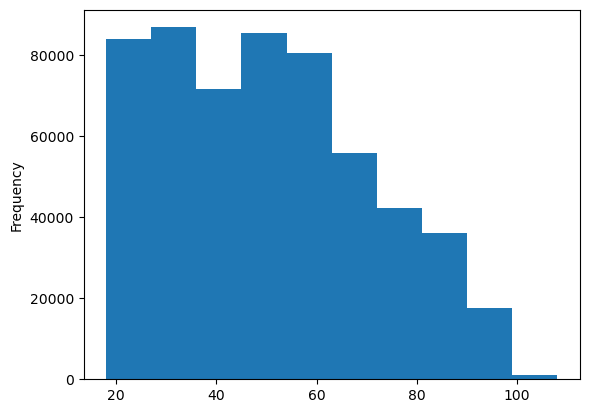

In [10]:
df.age.plot(kind="hist")

In [12]:
df.to_csv("Hospital Triage and Patient History.csv",index=False)

In [14]:
import os

old_name = "/Users/varshaponnaganti/Desktop/projects/healthcare/emergency/data/Hospital Triage and Patient History.csv"
new_name = "/Users/varshaponnaganti/Desktop/projects/healthcare/emergency/data/ed_patient_flow.csv"

os.rename(old_name, new_name)

print("File renamed successfully!")


File renamed successfully!


In [17]:
df.columns


Index(['dep_name', 'esi', 'age', 'gender', 'ethnicity', 'race', 'lang',
       'religion', 'maritalstatus', 'employstatus',
       ...
       'cc_vaginaldischarge', 'cc_vaginalpain', 'cc_weakness', 'cc_wheezing',
       'cc_withdrawal-alcohol', 'cc_woundcheck', 'cc_woundinfection',
       'cc_woundre-evaluation', 'cc_wristinjury', 'cc_wristpain'],
      dtype='object', length=972)

In [19]:
# Find any columns with time-related words
[c for c in df.columns if "time" in c.lower()]


['prothrombintime_last',
 'prothrombintime_min',
 'prothrombintime_max',
 'prothrombintime_median']

In [21]:
[c for c in df.columns if "wait" in c.lower()]


[]

In [23]:
[c for c in df.columns if "arrival" in c.lower()]


['arrivalmode', 'arrivalmonth', 'arrivalday', 'arrivalhour_bin']

In [27]:
df["esi"].dtype


CategoricalDtype(categories=['1', '2', '3', '4', '5'], ordered=False, categories_dtype=object)

In [31]:
import numpy as np

df["esi_num"] = pd.to_numeric(df["esi"], errors="coerce")


In [33]:
df["esi_num"].dtype
df["esi_num"].isna().sum()


2457

In [35]:
df = df.dropna(subset=["esi_num"])


In [37]:
df.shape


(558029, 973)

In [39]:
df["esi_num"].head()


0    4.0
1    4.0
2    2.0
3    2.0
4    3.0
Name: esi_num, dtype: float64

In [43]:
df.loc[:, "high_acuity"] = (df["esi_num"] <= 2).astype(int)


In [47]:
df["high_acuity"].value_counts()


high_acuity
0    389224
1    168805
Name: count, dtype: int64

0    389,224   (lower acuity)
1    168,805   (high acuity)


~30% high-acuity patients

~70% lower-acuity patients

This is realistic for ED data

Class imbalance is manageable (not extreme)

This is a very good dataset for classification.

In [52]:
# Target
target = "high_acuity"

# Chief complaint indicators
cc_cols = [c for c in df.columns if c.startswith("cc_")]

# Arrival pattern features
arrival_cols = [
    "arrivalmode",
    "arrivalmonth",
    "arrivalday",
    "arrivalhour_bin"
]

# Demographics
demo_cols = [
    "age",
    "gender",
    "race",
    "ethnicity",
    "lang",
    "maritalstatus",
    "employstatus"
]

print("Number of chief complaint features:", len(cc_cols))
print("Arrival features:", arrival_cols)
print("Demographic features:", demo_cols)


Number of chief complaint features: 200
Arrival features: ['arrivalmode', 'arrivalmonth', 'arrivalday', 'arrivalhour_bin']
Demographic features: ['age', 'gender', 'race', 'ethnicity', 'lang', 'maritalstatus', 'employstatus']


What We Know Now (Locked In)

Target: high_acuity

Chief complaint features: 200 binary indicators (cc_…)

Arrival features: 4

Demographics: 7

This is a very reasonable modeling setup.

In [55]:
#Remove Leakage Columns
# Columns to drop to prevent leakage
leakage_cols = ["esi", "esi_num"]

df_model = df.drop(columns=leakage_cols)

print(df_model.shape)


(558029, 972)


To prevent target leakage, I excluded triage severity variables used in outcome definition before model training.”

In [60]:
#Create X (features) and y (target)
# Define target
y = df_model["high_acuity"]

# Define features (everything except target)
X = df_model.drop(columns=["high_acuity"])

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (558029, 971)
y shape: (558029,)


In [64]:
#Identify Categorical vs Numeric Features
# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

print("Number of categorical features:", len(categorical_cols))
print("Number of numeric features:", len(numeric_cols))

print("\nSample categorical columns:", categorical_cols[:10])
print("\nSample numeric columns:", numeric_cols[:10])


Number of categorical features: 216
Number of numeric features: 755

Sample categorical columns: ['dep_name', 'age', 'gender', 'ethnicity', 'race', 'lang', 'religion', 'maritalstatus', 'employstatus', 'insurance_status']

Sample numeric columns: ['2ndarymalig', 'abdomhernia', 'abdomnlpain', 'abortcompl', 'acqfootdef', 'acrenlfail', 'acutecvd', 'acutemi', 'acutphanm', 'adjustmentdisorders']


In [70]:
X["age"].dtype


dtype('O')

In [72]:
# Make a safe copy first
X = X.copy()

# Convert age to numeric
X["age"] = pd.to_numeric(X["age"], errors="coerce")


In [74]:
X["age"].dtype


dtype('float64')

In [76]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object", "category"]).columns.tolist()

print("Number of categorical features:", len(categorical_cols))
print("Number of numeric features:", len(numeric_cols))


Number of categorical features: 215
Number of numeric features: 756


In [84]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols)
    ],
    remainder="passthrough"
)


In [86]:
#Train / Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))


X_train shape: (446423, 971)
X_test shape: (111606, 971)
y_train distribution:
 high_acuity
0    0.697498
1    0.302502
Name: proportion, dtype: float64




“Performed a stratified train-test split to preserve class distribution for a clinically imbalanced outcome.”

In [89]:
#Fit & Apply Preprocessing
# Fit preprocessor on training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform test data
X_test_processed = preprocessor.transform(X_test)

print("Processed X_train shape:", X_train_processed.shape)
print("Processed X_test shape:", X_test_processed.shape)


Processed X_train shape: (446423, 1530)
Processed X_test shape: (111606, 1530)


“Fitted preprocessing pipelines exclusively on training data and applied identical transformations to the test set to prevent data leakage.”